In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy


from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context

def save_df_to_text(obj, filename):
    obj.to_csv(filename, sep='\t')


In [2]:
sys.path.append('../../Code/')
from utils import read_dataset_log

In [3]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [4]:
cgep_path = read_dataset_log(tabname='cGEP Paths').iloc[0, :]
cgep_path

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
correlation_matrix_tpm_renorm_varnorm        /data/srlab1/TCAT/Data/TCAT/R.TPMrenorm.VarNor...
correlation_matrix_spectra                   /data

In [5]:
clus_df_labeled_clean = pd.read_csv(cgep_path.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clus_df_labeled_clean.head()

,AMP-RA,TBRU,UK-Covid,COMBAT,Pan-Cancer,Pan-Tissue,HIV-Vaccine
CellCycle-G2M,AMP-RA:CellCycle-G2M,TBRU:CellCycle-G2M,UK-Covid:CellCycle-G2M,COMBAT:CellCycle-G2M,Pan-Cancer:CellCycle-G2M,Pan-Tissue:CellCycle-G2M,HIV-Vaccine:CellCycle-G2M
CD4-Naive_Translation,AMP-RA:Translation,TBRU:Translation,UK-Covid:Translation,COMBAT:CD4-Naive,NaN,Pan-Tissue:Translation,HIV-Vaccine:Translation
HLA,AMP-RA:HLA,TBRU:HLA,UK-Covid:HLA,COMBAT:HLA,Pan-Cancer:HLA,Pan-Tissue:HLA,NaN
ISG,AMP-RA:ISG,TBRU:ISG,UK-Covid:ISG,COMBAT:ISG,Pan-Cancer:ISG,Pan-Tissue:ISG,HIV-Vaccine:ISG
MALAT1_Mito,NaN,TBRU:MALAT1,UK-Covid:Mito,COMBAT:Mito,NaN,Pan-Tissue:Mito,HIV-Vaccine:Mito


In [6]:
(~clus_df_labeled_clean.isnull()).sum(axis=0).sort_values()

HIV-Vaccine    31
AMP-RA         34
COMBAT         35
Pan-Cancer     38
Pan-Tissue     39
UK-Covid       44
TBRU           46
dtype: int64

In [7]:
cgep_info = read_dataset_log(tabname='cGEP_Name')
cgep_info.head()

,cGep_Name,Long_Name,Short_Name,New_Short_Name,Needs Review,Class,Num_Datasets,Notes,Reviewed,Filter
0,COMBAT_Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytoskeleton,NaN,Functional,7,NaN,Y,NaN
1,CD8_EM,CD8 Effector Memory,CD8-EM,CD8-EM,Y,Lineage,7,Need to confirm overlap with gating since the ...,Y,NaN
2,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,CellCycle-G2M,NaN,Functional,7,NaN,Y,NaN
3,CellCycle-S,Cell Cycle S Phase,CellCycle-S,CellCycle-S,NaN,Functional,7,NaN,Y,NaN
4,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,NaN,Functional,7,NaN,Y,NaN


In [8]:
filtered = list(cgep_info.loc[~cgep_info['Filter'].isnull(), 'cGep_Name'])

In [9]:
pd.Series(clus_df_labeled_clean.index.isin(filtered)).value_counts()

False    52
True     49
dtype: int64

In [10]:
num_overlaps = (~clus_df_labeled_clean.isnull()).sum(axis=1)
num_overlaps.loc[filtered] = 0
dataset_overlap_res = {}
for d in clus_df_labeled_clean.columns:
    dataset_overlap_res[d] = num_overlaps.loc[clus_df_labeled_clean.index[~clus_df_labeled_clean[d].isnull()]].value_counts()

dataset_overlap_res = pd.DataFrame.from_dict(dataset_overlap_res).replace(np.nan, 0).T

order = dataset_overlap_res.sum(axis=1).sort_values(ascending=False).index

dataset_overlap_res = dataset_overlap_res.loc[order, :]

In [11]:
num_overlaps.value_counts()

0    49
2    10
7     9
3     9
6     8
4     8
5     5
1     3
dtype: int64

In [12]:
(num_overlaps>=2).value_counts()

False    52
True     49
dtype: int64

In [13]:
(dataset_overlap_res.iloc[:, 2:].sum(axis=1) / dataset_overlap_res.sum(axis=1)).sort_values()

Pan-Cancer     0.684211
TBRU           0.760870
Pan-Tissue     0.769231
UK-Covid       0.772727
COMBAT         0.857143
AMP-RA         0.882353
HIV-Vaccine    0.967742
dtype: float64

/tmp/ipykernel_28209/2060192197.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dataset_overlap_res.index, rotation=90, fontsize=8)


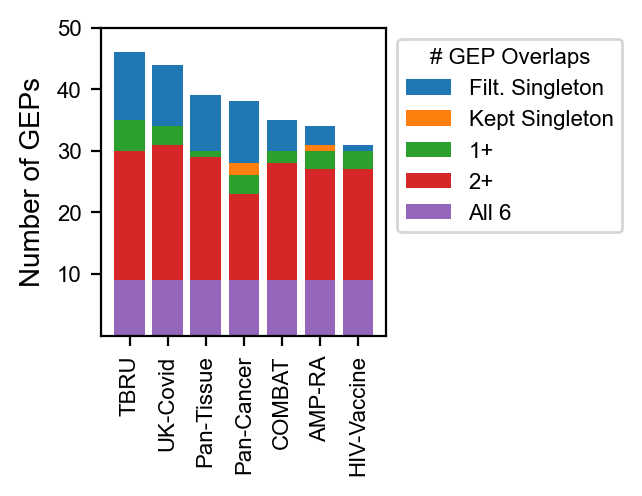

In [14]:
(fig, ax) = plt.subplots(1,1, figsize=(3,2), dpi=200, gridspec_kw={'right':.6})
ax.bar(x=dataset_overlap_res.index, height=dataset_overlap_res.sum(axis=1), label='Filt. Singleton')
ax.bar(x=dataset_overlap_res.index, height=dataset_overlap_res.iloc[:, 1:].sum(axis=1), label='Kept Singleton')
ax.bar(x=dataset_overlap_res.index, height=dataset_overlap_res.iloc[:, 2:].sum(axis=1), label='1+')
ax.bar(x=dataset_overlap_res.index, height=dataset_overlap_res.iloc[:, 3:].sum(axis=1), label='2+')
ax.bar(x=dataset_overlap_res.index, height=dataset_overlap_res.iloc[:, 7], label='All 6')

ax.set_xticklabels(dataset_overlap_res.index, rotation=90, fontsize=8)
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50], fontsize=8)
ax.set_ylabel('Number of GEPs', fontsize=10)
#ax.set_xlabel('Dataset', fontsize=10)
ax.legend(bbox_to_anchor=(1,1), title='# GEP Overlaps', fontsize=8, title_fontsize=8)
plt.savefig('../../Figures/Components/GEP_Overlap_Barplot_Summary.png', bbox_inches='tight')
plt.savefig('../../Figures/Components/GEP_Overlap_Barplot_Summary.pdf', bbox_inches='tight')

In [15]:
R = pd.read_csv(cgep_path['correlation_matrix_spectra'], sep = '\t', index_col = 0)

In [16]:
seveners = num_overlaps.index[num_overlaps==7]
corrs = []
for s in seveners:
    ind = clus_df_labeled_clean.loc[s, :].dropna().values
    corrs += list(R.loc[ind, ind].values[np.triu_indices(len(ind), k=1)])


pd.Series(corrs).mean()

0.8115961803259144

In [17]:
twoplus = num_overlaps.index[num_overlaps>=2]
corrs = []
for s in twoplus:
    ind = clus_df_labeled_clean.loc[s, :].dropna().values
    corrs += list(R.loc[ind, ind].values[np.triu_indices(len(ind), k=1)])


pd.Series(corrs).mean()

0.7416252935805593

In [18]:
R.loc[ind, ind].values[np.triu_indices(len(ind), k=1)]

array([0.48486897])

In [19]:
cgep_info

,cGep_Name,Long_Name,Short_Name,New_Short_Name,Needs Review,Class,Num_Datasets,Notes,Reviewed,Filter
0,COMBAT_Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytoskeleton,NaN,Functional,7,NaN,Y,NaN
1,CD8_EM,CD8 Effector Memory,CD8-EM,CD8-EM,Y,Lineage,7,Need to confirm overlap with gating since the ...,Y,NaN
2,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,CellCycle-G2M,NaN,Functional,7,NaN,Y,NaN
3,CellCycle-S,Cell Cycle S Phase,CellCycle-S,CellCycle-S,NaN,Functional,7,NaN,Y,NaN
4,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,NaN,Functional,7,NaN,Y,NaN
...,...,...,...,...,...,...,...,...,...,...
96,UK-Covid:UK-Covid:CRHBP/EGFL7_Single_Single,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,F
97,UK-Covid:UK-Covid:IEG3_Single_Single,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,F
98,UK-Covid:UK-Covid:ITGA2/GATA2_Single_Single,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,F
99,UK-Covid:UK-Covid:KRT17/DDAH1_Single_Single,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,F


In [23]:
cgep_info.loc[cgep_info['Filter'].isnull(), 'Class'].value_counts()

Functional         25
Lineage            17
Doublet Lineage     6
Artifact            4
Name: Class, dtype: int64

In [24]:
cgep_info.loc[cgep_info['Filter'].isnull(), 'Class'].value_counts().sum()

52

In [ ]:
cgep_info.loc[cgep_info['Filter'].isnull(), 'Class'].value_counts()

In [25]:
ind = cgep_info['Filter'].isnull() & (cgep_info['Class'] == 'Functional')
cgep_info.loc[ind, :]

,cGep_Name,Long_Name,Short_Name,New_Short_Name,Needs Review,Class,Num_Datasets,Notes,Reviewed,Filter
0,COMBAT_Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytoskeleton,NaN,Functional,7,NaN,Y,NaN
2,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,CellCycle-G2M,NaN,Functional,7,NaN,Y,NaN
3,CellCycle-S,Cell Cycle S Phase,CellCycle-S,CellCycle-S,NaN,Functional,7,NaN,Y,NaN
4,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,NaN,Functional,7,NaN,Y,NaN
6,ISG,Interferon Stimulated Genes,ISG,ISG,NaN,Functional,7,NaN,Y,NaN
10,CellCycle-Histone,Cell Cycle Late S-phase,CellCycle-Late-S,CellCycle-Late-S,NaN,Functional,6,NaN,Y,NaN
11,HLA,Class 2 HLA,HLA,HLA,NaN,Functional,6,NaN,Y,NaN
12,HeatShock2,Early Activation Associated,Early-Activation,Early-Activation,NaN,Functional,6,NaN,Y,NaN
15,CD4-Naive_Translation,Translation,Translation,Translation,NaN,Functional,6,NaN,Y,NaN
19,IL10/CD38,IL10/CD38-Associated,IL10/IL19-Secretion,IL10/IL19,NaN,Functional,5,NaN,Y,NaN
